In [173]:
#Import Packages
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import camb 
from camb import model, initialpower
import glob
import pylab as plty
from PIL import Image

%matplotlib inline


In [61]:
def basicgenmap(_strt, _stop, _NSIDE):  # (start, stop, NSIDE)
    '''
    Generate a basic map which is just an array with element values which are increasing from a 'start' to a 'stop'.
    '''
    _NPIX = 12*_NSIDE**2 #The number of pixels in a map, NPIX = 12*(NSIDE)^2
    return   np.linspace(_strt,_stop,_NPIX)        #generates an array in the 'ring' scheme


In [62]:
#Use CAMB to generate a power spectrum
def call_CAMB_map(_parameters, _lmax): #lmax above 2551 makes no difference?
    '''
    parameters = [H0, ombh2, omch2, mnu, omk, tau]  = [Hubble Const, Baryon density, DM density, 
    Sum 3 neutrino masses/eV, Curvature parameter (Omega kappa), Reionisation optical depth]
    '''
    if _lmax <= 2551: #can only find power spectrum for lmax <= 2551 since that is the maximum value of the data.
        pars = camb.CAMBparams()
        pars.set_cosmology(H0 = _parameters[0], ombh2 = _parameters[1], omch2 = _parameters[2], mnu = _parameters[3],
                   omk = _parameters[4], tau = _parameters[5])  #Inputs the given cosmological parameters.
        pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
        
        pars.set_for_lmax(_lmax, lens_potential_accuracy=0) #input the given lmax value
        
        results = camb.get_results(pars)
        powers =results.get_cmb_power_spectra(pars, CMB_unit='muK') #returns the power spectrum in units muK.
        
        totCL=powers['total'] #returns the total (averaged) power spectrum - including lensed, unlensed power spectra 
        _DL = totCL[:,0] 
        
        #unlensedCL=powers['unlensed_scalar'] #returns the unlensed scalar power spectrum
        #_DL = unlensedCL[:,0] # 
    
        _l = np.arange(len(_DL)) #not sure this CL is actually CL but is actually DL
        _CL = []
        for i in range(_lmax): #also limits the length of power spectrum to the requested length
            if i == 0:
                _CL.append(_DL[i]) #since unsure what CL value is for this DL
        
            else:
                _CL.append(_DL[i]/(_l[i]*(_l[i] + 1)))
        
        _CL = np.array(_CL)    
    
        return _CL 
    
    else: #prints error if lmax is too large.
        print('lmax value is larger than the available data.')

In [159]:
#Plots a given power spectrum 
def plotpwrspctrm(_cls):
    _l = np.arange(len(_cls))
    plt.plot(_l, _l * (_l + 1) * _cls)
    plt.xlabel("$\l$")
    plt.ylabel("$\l(\l+1)C_{\l}$")
    plt.grid()
    plt.title("Power Spectrum")

#PLots a map in the mollview projection 
def mollviewmap(_map):
    hp.mollview(_map, title="Map displayed in the Aithoff projection", cmap = None)
    hp.graticule()


In [64]:
#Adds random noise to each pixel on a map given a variance 
def noisemap(_map,_var):
    _noisevec = np.random.normal(0,_var,len(_map))
    _newmap = [x + y for x, y in zip(_map, _noisevec)]
    _newmap, _noisevec = np.array(_newmap), np.array(_noisevec)
    return [_newmap, _noisevec] #returns an array consisiting of [map with added noise, array of the added noise]


In [65]:
#cls --> something
def cltoalm(_cls, _NSIDE): #does this manually - doesn't work
    _alms = []
    _lmax = (3*_NSIDE)
    _count = 0
    for l in range(_lmax): 
        if _cls[l] > 0:
            _alms.append(np.complex(np.random.normal(0,_cls[l]),0))        #set m=0, which is real
        else:
            _alms.append(np.complex(0,0))
        
        for m in range(l): #set positive m's
            if _cls[l] > 0 and _cls[m] > 0:
                _alms.append(np.complex(np.random.normal(0,0.5*_cls[l]),np.random.normal(0,0.5*_cls[m])))
            if _cls[l] > 0 and _cls[m] <= 0:
                _alms.append(np.complex(np.random.normal(0,0.5*_cls[l]),0))
            if _cls[l] <= 0 and _cls[m] > 0:
                _alms.append(np.complex(0,np.random.normal(0,0.5*_cls[m])))
            else:
                _alms.append(np.complex(0,0))
    
    return _alms   

def hpcltoalm(_cls, _NSIDE): #Healpy generate alms given cls
    return hp.synalm(_cls, lmax = (3*_NSIDE) - 1, new = True)

def cltomap(_cls, _NSIDE):
    _alm = cltoalm(_cls, _NSIDE)
    return almtomap(_alm, _NSIDE)

def hpcltomap(_cls, _NSIDE):   #Healpy generate a map given a power spectrum
    return hp.synfast(_cls, _NSIDE, new=True)   #pixwin=False, fwhm=np.radians(7.0),


In [66]:
#map --> something
def maptocl(_map):
    return

def hpmaptocl(_map): #Generate a power spectrum given cls
    return hp.anafast(_map, lmax=int(((3*(len(_map)/12)**0.5)-1)))    #lmax = 3NSIDE -1 by default

def maptoalm(_map):
    _omegp = (4*np.pi)/len(_map)
    _lmax = int(np.sqrt(len(_map)*(3/4)))
    _NSIDE = int(_lmax/3)
    _alm = []
    for l in range(_lmax):
        for m in range(l+1):
            _TpYlm = []
            for i in range(len(_map)):
                _TpYlm.append(_map[i]*np.conjugate(sphharm(m, l, i, _NSIDE)))
                    
            _alm.append(_omegp*sum(_TpYlm))
    
    return _alm


def hpmaptoalm(_map, _lmax): #Healpy generate alms from map. 
    return hp.map2alm(_map, _lmax)


In [67]:
#alm --> something
def almtocl(_alm,lmax): #not the same value as healpy
    _l = np.arange(lmax)
    _scaling = 1 / ((2*_l + 1))
    count = 0
    _new = []
    _cl = []
    for l in range(lmax):
        _new.append([])
        for m in range(l):
            if m == 0:
                _new[l].append(np.absolute(_alm[count])**2)
                count = count + 1
                
            if m > 0:
                _new[l].append(2*np.absolute(_alm[count])**2)
                count = count + 1
              
    for i in range(len(_new)):
        _cl.append(_scaling[i] * sum(_new[i]))
    
    return _cl

def hpalmtocl(_alms, _lmax): #Healpy estimates the power spectrum from the cls.
    return hp.alm2cl(_alms, lmax = _lmax)

def almtomap(_alm, _NSIDE):# alm --> map 
    _map = []
    _lmax = (3*_NSIDE)
    for i in range(12*(_NSIDE)**2):
        _sum = []
        _count = 0
        for l in range(_lmax+1):
            for m in range(l):
                _sum.append(_alm[_count]*sphharm(m,l,i, _NSIDE))
                _count = _count + 1
        _map.append(abs(sum(_sum)))
    return _map

def almtomap_tf(_alm, _NSIDE): #alm --> map for tensorflow 
    _map = tf.constant([])
    _lmax = (3*_NSIDE)
    for i in range(12*(_NSIDE)**2):
        _sum = tf.constant([])
        _count = 0
        for l in range(_lmax+1):
            for m in range(l):
                _sum = tf.concat((_sum,[_alm[_count]*sphharm(m,l,i, _NSIDE)]), axis = 0)
                _count = _count + 1
        _map = tf.concat((_map,[abs(sum(_sum))]), axis = 0)
    return tf.convert_to_tensor(_map)


def hpalmtomap(_alms, _NSIDE):
    return hp.alm2map(_alms, _NSIDE)

In [68]:
#healpy smoothing for the map and the alms
def hpmapsmooth(_map, _lmax): #smooths a given map with a gaussian beam smoother.
    return hp.smoothing(_map, lmax = _lmax)

def hpalmsmooth(_alms): #smooths a given set of alms with a gaussian beam smoother.
    return hp.smoothalm(_alms, fwhm = 0.0)
    

In [69]:
#splits/rejoins the alms into real/imaginary parts so that they can be optimised with scipy.optimize.minimize()
def singulartosplitalm(_alm):
    _realalm, _imagalm = _alm.real, _alm.imag
    return [_realalm, _imagalm]
    

def splittosingularalm(_realalm, _imagalm):
    _alm = []
    for i in range(len(_realalm)):
        _alm.append(complex(_realalm[i], _imagalm[i]))
    return _alm

def splittosingularalm_tf(_realalm, _imagalm): #takes the real and imaginary parts of the alms and creates a tensor
    return tf.complex(_realalm,_imagalm)

In [70]:
#Retrieves the spherical harmonics for a given, l, m and pixel number
def sphharm(m, l, _pixno, _NSIDE):
    _theta, _phi = hp.pix2ang(nside=_NSIDE, ipix=_pixno)
    return sp.special.sph_harm(m, l, _theta, _phi)
    

In [71]:
#negative log of the posterior, psi.
def psi(_params, _map, _lmax, _Ninv): #unnormalised log probability
    _cl, _realalm, _imagalm = [], [], []
    
    for i in range(len_cl):
        _cl.append(_params[i])
    for i in range(len_ralm):
        _realalm.append(_params[i + len_cl])
    for i in range(len_ialm):
        _imagalm.append(_params[i + len_cl + len_ralm])
    
    _d = _map
    _a = splittosingularalm(_realalm, _imagalm)
    _Ya = almtomap(_a, int(_lmax/3))
    _BYa =  _Ya #mapsmooth(_Ya, _lmax)
    
    _elem, _psi1 ,_psi2, _psi3 = [], [], [], []
    for i in range(len(_d)):
        _elem.append(_d[i] - _BYa[i])
        _psi1.append(0.5*(_elem[i]**2)*_Ninv[i]) #first term in the taylor paper 
    
    for l in range(_lmax):
        if _cl[l] > 0:
            _psi2.append((2*l+1)*np.log(_cl[l])) #second term in the taylor paper
    
    for i in range(len(_a)):
        _psi3.append(abs(_a[i])**2)
        
    _psi = sum(_psi1) + sum(_psi2) + sum(_psi3) #third term in the taylor paper
    print('psi =',_psi)
    return _psi

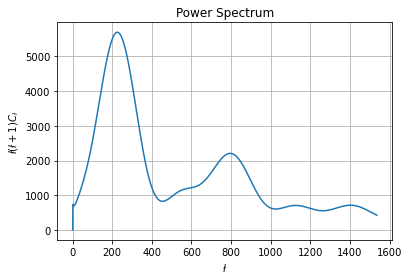

/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colorm

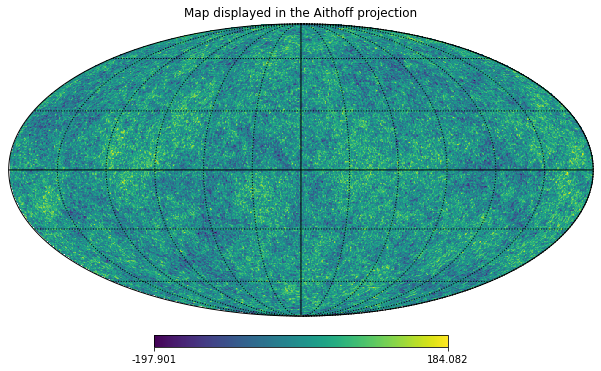

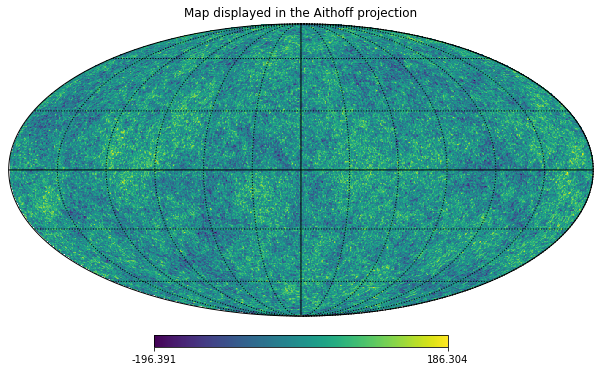

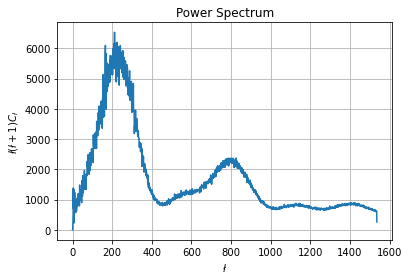

In [21]:
#Trial with parameters 1
parameters1 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax1 = 1536  #lmax value wanted from data
NSIDE1 = int(lmax1/3)  #len(cls1)/3   #3*nside = len(cls)
n1 = np.linspace(5,5,(12*(NSIDE1)**2))
Ninv1 = []
for i in range(len(n1)):
    Ninv1.append(1/(n1[i]**2)) #finds the inverse noise matrix

cls1 = call_CAMB_map(parameters1, lmax1) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls1) #plot of the power spectrum.
map1 = hpcltomap(cls1, NSIDE1)  #generates a map from the power spectrum
map1 = hpmapsmooth(map1, lmax1) #applies a gaussian beam smoother to the map
mollviewmap(map1) #plots the map
noisemap1 = noisemap(list(map1),n1[0])[0] #adds noise to the map
mollviewmap(noisemap1) #plots the map with noise
alms1 = hpmaptoalm(noisemap1,lmax1) #computes the alms from the map with noise added.
CLestimate1 = hpalmtocl(alms1, lmax1) #estimates the power spectrum from the given alms.
plotpwrspctrm(CLestimate1) #plots the estimated power spectrum.


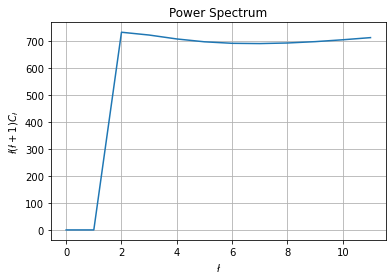

/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colorm

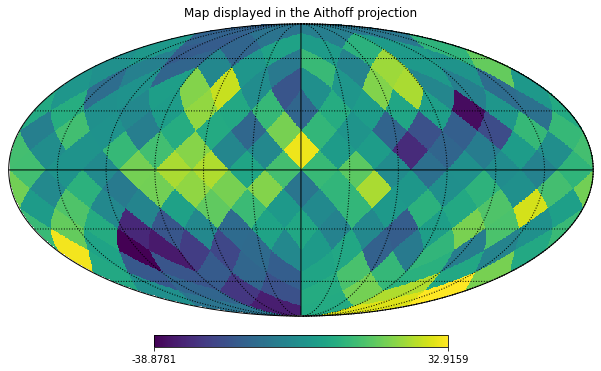

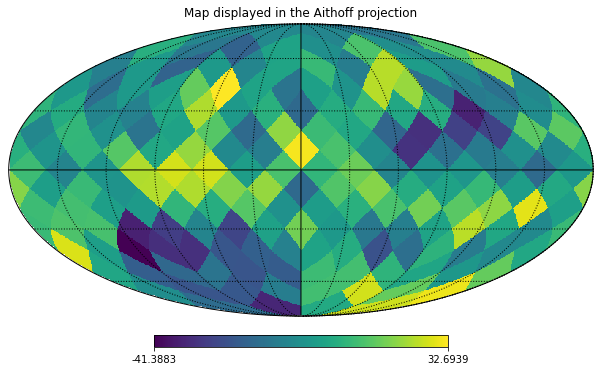

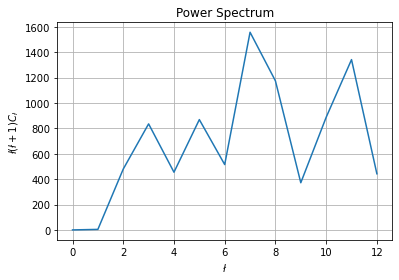

In [22]:
#Trial with parameters 2
parameters2 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax2 = 12   #lmax value wanted from data
NSIDE2 = int(lmax2/3)   #len(cls1)/3   #3*nside = len(cls)
n2 = np.linspace(5,5,(12*(NSIDE2)**2))
Ninv2 = []
for i in range(len(n2)):
    Ninv2.append(1/(n2[i]**2)) #finds the inverse noise matrix
    

cls2 = call_CAMB_map(parameters2, lmax2) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls2) #plot of the power spectrum.
map2 = hpcltomap(cls2, NSIDE2)  #generates a map from the power spectrum
map2 = hpmapsmooth(map2, lmax2) #applies a gaussian beam smoother to the map
mollviewmap(map2) #plots the map
noisemap2 = noisemap(map2,n2[0])[0] #adds noise to the map
mollviewmap(noisemap2) #plots the map with noise
alms2 = hpmaptoalm(noisemap2,lmax2) #computes the alms from the map with noise added.
CLestimate2 = hpalmtocl(alms2, lmax2) #estimates the power spectrum from the given alms.
plotpwrspctrm(CLestimate2) #plots the estimated power spectrum.


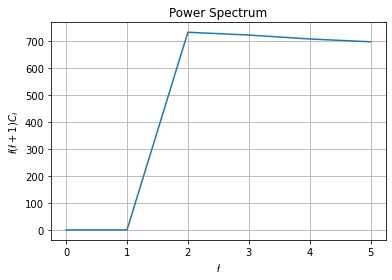

/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colorm

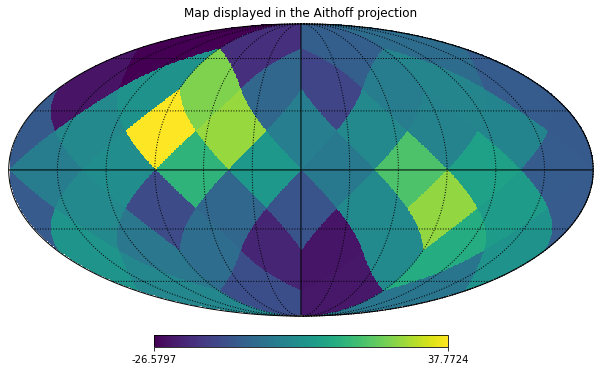

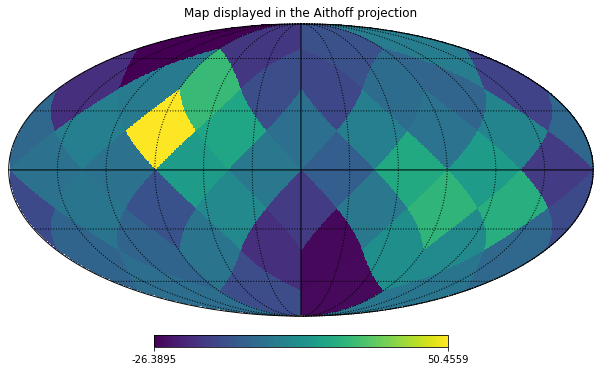

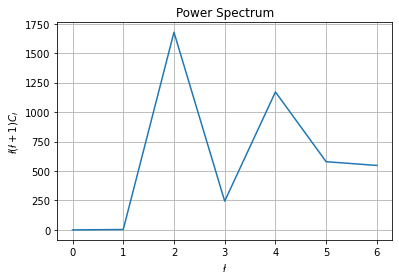

In [23]:
#Trial with parameters 3
parameters3 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax3 = 6  #lmax value wanted from data
NSIDE3 = int(lmax3/3)  #len(cls1)/3   #3*nside = len(cls)
n3 = np.linspace(5,5,(12*(NSIDE3)**2))
Ninv3 = []
for i in range(len(n3)):
    Ninv3.append(1/(n3[i]**2)) #finds the inverse noise matrix

cls3 = call_CAMB_map(parameters3, lmax3) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls3) #plot of the power spectrum.
map3 = hpcltomap(cls3, NSIDE3)  #generates a map from the power spectrum
map3 = hpmapsmooth(map3, lmax3) #applies a gaussian beam smoother to the map
mollviewmap(map3) #plots the map
noisemap3 = noisemap(map3,n3[0])[0] #adds noise to the map
mollviewmap(noisemap3) #plots the map with noise
alms3 = hpmaptoalm(noisemap3,lmax3) #computes the alms from the map with noise added.
CLestimate3 = hpalmtocl(alms3, lmax3) #estimates the power spectrum from the given alms.
plotpwrspctrm(CLestimate3) #plots the estimated power spectrum.


/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


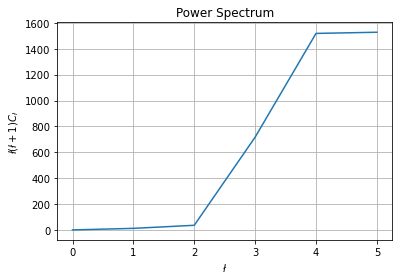

In [72]:
#Trial with parameters 4
parameters4 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax4 = 6  #lmax value wanted from data
NSIDE4 = int(lmax4/3)  #len(cls1)/3   #3*nside = len(cls)
n4 = np.linspace(5,5,(12*(NSIDE4)**2))
Ninv4 = []
for i in range(len(n4)):
    Ninv4.append(1/(n4[i]**2)) #finds the inverse noise matrix
    
cls4 = call_CAMB_map(parameters4, lmax4) #power spectrum for the given parameters and lmax.
map4 = hpcltomap(cls4, NSIDE4)  #generates a map from the power spectrum
map4 = hpmapsmooth(map4, lmax4) #applies a gaussian beam smoother to the map
noisemap4 = noisemap(map4,n4[0])[0] #adds noise to the map

noisealm4 = np.array(maptoalm(noisemap4)) #recover cls from map
noisecl4 = almtocl(noisealm4, lmax4)
plotpwrspctrm(noisecl4) #plots the estimated power spectrum.


In [73]:
#inital values for the optimisation of psi (with the values from parameters4)
noisemap = noisemap4
clinit = noisecl4
realalminit = noisealm4.real
imagalminit = noisealm4.imag
x0 = []
len_cl = len(clinit)
len_ralm = len(realalminit)
len_ialm = len(imagalminit)
for i in range(len(clinit)):
    x0.append(clinit[i])
for i in range(len(realalminit)):
    x0.append(realalminit[i])
for i in range(len(imagalminit)):
    x0.append(imagalminit[i])
    
print('psi_init = ',psi(x0,noisemap,lmax4,Ninv4))

psi = 1719.112763469523
psi_init =  1719.112763469523


In [123]:
#Optimising the parameters of the posterior (the 'psi' funciton), to get the parameters corresponding to its min.
sp.optimize.fmin(psi, x0, args = (noisemap, lmax4, Ninv4), xtol=5)


psi = 1719.112763469523
psi = 1710.818713829421
psi = 1719.2591339620317
psi = 1719.3567142903703
psi = 1719.4542946187094
psi = 1719.5518749470482
psi = 1719.649455275387
psi = 1722.2711246389467
psi = 1720.4564492412956
psi = 1720.258324214767
psi = 1748.0373509619667
psi = 1723.407139091907
psi = 1722.0307744215143
psi = 1719.1213181294315
psi = 1719.6027956046285
psi = 1720.8482901804282
psi = 1721.727078589985
psi = 1719.0761067473345
psi = 1721.4311076408283
psi = 1733.884045242277
psi = 1719.7699411422768
psi = 1730.6436736067142
psi = 1721.1163610114725
psi = 1720.243002019178
psi = 1720.0610703362872
psi = 1719.248260497537
psi = 1723.3329786788
psi = 1719.131091832907
psi = 1719.112616997877
psi = 1719.1123956868569
psi = 1719.083099418645
psi = 1719.1129812105112
psi = 1719.9731189867455
psi = 1722.1506062961785
psi = 1719.1126385020139
psi = 1744.2625371846048
psi = 1723.1233625368031
psi = 1727.894873884116
psi = 1719.1127959720611
psi = 1719.5257565345055
psi = 1719.37354

psi = 1505.3936307360138
psi = 1504.1675328908614
psi = 1503.301669153599
psi = 1502.468276800354
psi = 1501.7672783821356
psi = 1501.1577451269184
psi = 1499.7777429053508
psi = 1478.3276925446805
psi = 1498.0469555981344
psi = 1496.4903465106981
psi = 1496.1287078897744
psi = 1494.0745334409403
psi = 1494.559801750779
psi = 1493.6663459710499
psi = 1492.907387143605
psi = 1491.8723725428645
psi = 1490.777788173244
psi = 1489.5763401057636
psi = 1488.1559604527097
psi = 1486.751641699811
psi = 1496.4127148247048
psi = 1486.3124616529103
psi = 1484.8934162611706
psi = 1483.9108502179074
psi = 1482.5258448587272
psi = 1480.513695790522
psi = 1479.3267748445792
psi = 1478.3116280560764
psi = 1455.1026133101554
psi = 1476.1673209754226
psi = 1474.9354518648224
psi = 1473.3286087662987
psi = 1472.971405681409
psi = 1473.3711678671389
psi = 1473.4196344046304
psi = 1472.852867278369
psi = 1471.2054866912224
psi = 1470.4238307515768
psi = 1469.6212596429568
psi = 1468.2753808743805
psi = 146

psi = 1209.715227383221
psi = 1209.918437301649
psi = 1208.2155391244303
psi = 1206.406845353308
psi = 1202.8670632555627
psi = 1206.7057938014038
psi = 1205.3485184110118
psi = 1201.9124862696917
psi = 1185.951463537558
psi = 1204.6254050954096
psi = 1202.1803061897272
psi = 1224.9289189280685
psi = 1202.793356543364
psi = 1202.6158813892885
psi = 1200.6125499761074
psi = 1198.6819991315763
psi = 1199.0858943760009
psi = 1197.5184520545595
psi = 1201.466451612727
psi = 1199.3046154473877
psi = 1197.80089687837
psi = 1197.7050707418316
psi = 1197.7333677191496
psi = 1196.0646503194298
psi = 1210.4739819764568
psi = 1194.364730240708
psi = 1195.173698948114
psi = 1192.789530517095
psi = 1193.874448703959
psi = 1193.8976484948903
psi = 1192.725568360799
psi = 1191.3409990601617
psi = 1190.2472837416053
psi = 1189.540870745097
psi = 1191.9319950958472
psi = 1189.1532130730359
psi = 1188.8135865425745
psi = 1189.9173488464635
psi = 1188.467524140503
psi = 1187.7129139883791
psi = 1188.7630

psi = 997.397525099658
psi = 996.9914329602882
psi = 1003.7882196055623
psi = 994.3336306992783
psi = 993.9970482435624
psi = 995.9662831510427
psi = 990.5857207379588
psi = 989.378364081384
psi = 989.2443171781154
psi = 987.5368778208685
psi = 986.6713500978543
psi = 986.3050516779364
psi = 988.9912916175352
psi = 984.5423645838792
psi = 984.4272184284713
psi = 983.2771966444012
psi = 981.7920256793848
psi = 981.0225432721758
psi = 980.7559382423524
psi = 961.9760648209308
psi = 977.8817939928663
psi = 994.1579332964031
psi = 976.0192437235474
psi = 975.4848440539831
psi = 980.8795093985211
psi = 974.8122482232446
psi = 972.1357650931539
psi = 971.6355779765255
psi = 972.0638359623375
psi = 971.8014842078734
psi = 970.5240482618365
psi = 974.7415639178329
psi = 968.1443715922466
psi = 966.9763565383914
psi = 966.6062990367325
psi = 964.8680782352827
psi = 966.1071352101436
psi = 965.2211705160073
psi = 962.7900274642008
psi = 961.684806302861
psi = 941.4906749971076
psi = 960.72652066

psi = 777.1714289250847
psi = 771.6894048647905
psi = 764.6558956515624
psi = 765.838817414512
psi = 764.6941060274964
psi = 766.3495515493312
psi = 764.4520726381929
psi = 772.0930226755545
psi = 767.3499707599498
psi = 766.9277531291391
psi = 763.2449106292531
psi = 762.1088222547027
psi = 773.2432970174534
psi = 763.2272667624104
psi = 764.9445403205846
psi = 763.9704357938288
psi = 769.2604205204353
psi = 764.3543178912659
psi = 763.0052069792469
psi = 768.9703956977921
psi = 764.6023829422659
psi = 761.2402168268538
psi = 757.3047605015513
psi = 770.8147161739831
psi = 763.9672781391773
psi = 770.4288152788349
psi = 760.1496324287618
psi = 763.3676538395976
psi = 758.3006140598361
psi = 762.0319467382146
psi = 763.3228001121706
psi = 767.124761372114
psi = 759.6655091455748
psi = 759.5663924142976
psi = 760.1833462334707
psi = 757.566931824367
psi = 759.9915451086334
psi = 756.5221622562648
psi = 750.6442406503456
psi = 767.198729105628
psi = 758.8932351375414
psi = 765.5190421495

psi = 658.2164231202303
psi = 642.5780046136811
psi = 655.8565906400944
psi = 642.9365524150053
psi = 646.7592105736874
psi = 663.7987478799312
psi = 648.3276195861896
psi = 665.0775062891435
psi = 655.9984704916299
psi = 641.2925792979951
psi = 641.5044601391728
psi = 642.8181642701636
psi = 637.0719192080085
psi = 647.8641185731617
psi = 640.125258563315
psi = 636.4944756974545
psi = 655.0250356718902
psi = 636.8492611221563
psi = 643.6540087761942
psi = 642.5000823584824
psi = 638.5858000388312
psi = 650.2230963643316
psi = 636.8502438600129
psi = 643.7553995613914
psi = 648.3658271512229
psi = 632.9623493105435
psi = 643.303466825647
psi = 637.5814403524548
psi = 646.6105083229879
psi = 644.5496825139478
psi = 639.9753722372648
psi = 649.5280353029968
psi = 637.7079306172791
psi = 648.7848060829168
psi = 645.5139719700937
psi = 637.2258307184007
psi = 629.3128052046975
psi = 618.7377382070479
psi = 635.6735516689039
psi = 632.2339789070766
psi = 634.7498065343025
psi = 621.92002074

psi = 613.0493621505333
psi = 612.7702913632327
psi = 612.9821474652006
psi = 612.7770217597196
psi = 612.8870262809247
psi = 612.7881864982653
psi = 613.1045740178267
psi = 612.7622093297225
psi = 612.8646420776037
psi = 612.7911811835812
psi = 612.9015188330552
psi = 612.7869453869262
psi = 612.8970866964269
psi = 612.787374064076
psi = 612.9928603897129
psi = 612.7755944900141
psi = 612.8294243789129
psi = 612.7954091822504
psi = 595.786604619698
psi = 594.460634866011
psi = 600.6506475471731
psi = 596.2209854656621
psi = 597.7747066020825
psi = 609.8907083764423
psi = 610.5196494296201
psi = 611.7014139925893
psi = 611.7532422652339
psi = 605.0458702671249
psi = 612.4262026389133
psi = 601.4939200199332
psi = 612.4300115259954
psi = 613.0525922791907
psi = 604.9897127131152
psi = 613.9375931181892
psi = 613.7883479334263
psi = 613.5513441398004
psi = 613.2879412606422
psi = 613.2815809193264
psi = 613.0644627052139
psi = 613.564737824854
psi = 613.6818103860389
psi = 613.7740307774

psi = 617.0540174151699
psi = 617.0546032982429
psi = 617.0546192141303
psi = 617.0548074388396
psi = 617.054940164928
psi = 617.0551351025993
psi = 617.0551269278853
psi = 617.0552979349667
psi = 617.0553080158364
psi = 617.0553004111516
psi = 590.6889985080105
psi = 590.6901645868572
psi = 590.7517436398191
psi = 590.770453590068
psi = 590.9125160173893
psi = 591.0058255442483
psi = 591.2909690006984
psi = 591.4382294852312
psi = 617.0336420556303
psi = 617.0515603999157
psi = 617.0703942648743
psi = 617.0798321143704
psi = 617.0806641035106
psi = 617.0813453537965
psi = 617.0862080737481
psi = 617.0878433704802
psi = 617.0930624533314
psi = 617.0941980057272
psi = 617.0955571143594
psi = 617.100683863696
psi = 575.2510596679219
psi = 567.8138248662289
psi = 617.1030530051785
psi = 617.1044572706687
psi = 569.2747038001871
psi = 617.1076869273791
psi = 552.8342028620352
psi = 617.1100324639789
psi = 617.1110986127711
psi = 617.1112059591534
psi = 617.1114830089512
psi = 617.111811041

psi = 617.1095390256116
psi = 576.3298856906189
psi = 617.1099793887955
psi = 576.2481362244646
psi = 617.1102360100388
psi = 576.1782447684018
psi = 617.1099017328042
psi = 576.1017126379372
psi = 617.1103351809878
psi = 576.0315876658271
psi = 617.1129552400587
psi = 575.9854387805426
psi = 617.1102357437974
psi = 575.9329745589076
psi = 617.110253358873
psi = 575.8604709403311
psi = 617.1104067461965
psi = 575.7878447855527
psi = 617.1098898411378
psi = 575.7138164838049
psi = 617.1088807940982
psi = 575.6354590092047
psi = 617.1099762043506
psi = 575.5680629524722
psi = 617.1096083780446
psi = 575.4981641846978
psi = 617.1100353289096
psi = 575.427146077864
psi = 617.1103225557358
psi = 575.3232340438077
psi = 617.1109997881874
psi = 575.2560570856006
psi = 617.1108151607698
psi = 575.1884397774513
psi = 617.1091858709574
psi = 575.0122116076125
psi = 617.1072492577994
psi = 574.9736392342089
psi = 617.1092762415001
psi = 574.8281840462638
psi = 556.5898863384894
psi = 552.34537263

psi = 560.2501267322166
psi = 617.1103883759836
psi = 560.1672990652739
psi = 617.1103767081852
psi = 560.0926827847866
psi = 617.1103927729389
psi = 560.0119912792929
psi = 617.1102489521577
psi = 559.9405169994633
psi = 617.1102128748495
psi = 559.8157411994027
psi = 617.1104266632442
psi = 559.7431638271992
psi = 617.1101200436508
psi = 559.6629276979901
psi = 617.1116472175152
psi = 559.5719039569263
psi = 520.0593113235734
psi = 617.110316239536
psi = 559.0666840987283
psi = 617.1104554781539
psi = 558.99708918601
psi = 617.1108174743517
psi = 558.9315669896752
psi = 617.1104352080465
psi = 558.863051274618
psi = 617.1104091387919
psi = 558.7921611977772
psi = 617.1100097640738
psi = 558.7323340951159
psi = 617.1104336057635
psi = 558.6989322636334
psi = 617.110259110842
psi = 558.631305002046
psi = 617.1104461921316
psi = 558.5593561030823
psi = 617.1104380482504
psi = 558.485914709612
psi = 617.1103655785698
psi = 558.4170356694091
psi = 617.1104431416643
psi = 558.3421365138832

psi = 617.1105529891017
psi = 543.588415277397
psi = 617.110552384536
psi = 543.5137290256455
psi = 617.1106295860014
psi = 543.4452383112008
psi = 617.1105498194697
psi = 543.3788542197087
psi = 617.1105492348042
psi = 543.3036811029197
psi = 617.1104763462108
psi = 543.236224963539
psi = 617.1105469180604
psi = 543.186795053898
psi = 617.1105461740456
psi = 543.1093474010743
psi = 617.1111790294294
psi = 543.0428589231695
psi = 617.110537467215
psi = 542.972257435298
psi = 617.1105354615308
psi = 542.8959274232667
psi = 617.1105395788521
psi = 542.8192475655089
psi = 617.1106427514667
psi = 542.7339182185067
psi = 523.3274725589281
psi = 517.2991645587962
psi = 617.1104978479086
psi = 542.0650969779009
psi = 617.1105507801971
psi = 542.007853348775
psi = 617.1105502275142
psi = 541.9349428862306
psi = 617.1105494567826
psi = 541.8622087537798
psi = 617.1105491939044
psi = 541.7892687934207
psi = 617.1098878553314
psi = 541.7246108144194
psi = 617.1105194021325
psi = 541.6706585512424

psi = 617.1109895149393
psi = 526.8525168537775
psi = 617.1109898052453
psi = 526.7793442702877
psi = 617.110989857759
psi = 526.7064569072062
psi = 617.1110081242653
psi = 526.6371045185422
psi = 617.1109903771921
psi = 526.570070149595
psi = 617.1109906622937
psi = 526.4962731790315
psi = 617.1111035839435
psi = 526.4428090389665
psi = 617.1110764069764
psi = 526.3780956897988
psi = 617.1105211128247
psi = 526.3096214626878
psi = 617.1110039812593
psi = 526.2439154652204
psi = 617.1110020933811
psi = 526.1685565521791
psi = 617.1110789012462
psi = 526.1006149135035
psi = 617.1110028566952
psi = 526.027796214396
psi = 617.1110015483007
psi = 525.9547837087807
psi = 617.1110019448251
psi = 525.8784063520685
psi = 617.1110026663002
psi = 525.8017323403728
psi = 617.1114030645755
psi = 525.6768070114599
psi = 508.89124500339335
psi = 505.6308123201798
psi = 499.00657431819855
psi = 617.1109967296968
psi = 524.8114034523089
psi = 617.1109969469807
psi = 524.7386376964262
psi = 617.1109970

psi = 617.1118508735744
psi = 509.247445859615
psi = 617.1115451511582
psi = 509.18542363802675
psi = 617.1114794832222
psi = 509.1148968096486
psi = 617.1117574804472
psi = 509.0544995602305
psi = 617.1117583969017
psi = 508.97870812439294
psi = 617.1118555741375
psi = 508.90527726250383
psi = 617.1117593725614
psi = 508.84189516081824
psi = 617.1117736869093
psi = 508.76568960147733
psi = 617.1117620227094
psi = 508.6938725686035
psi = 617.1117671252739
psi = 508.60571726974706
psi = 617.1117744466179
psi = 508.53127584976863
psi = 617.1119109737474
psi = 508.41644037002874
psi = 617.1122777151136
psi = 508.3674597431726
psi = 617.1118133607084
psi = 508.32755929555117
psi = 617.1120383371733
psi = 508.21885706619173
psi = 490.47731249195397
psi = 486.52369842855586
psi = 475.3907814226996
psi = 617.111844854495
psi = 617.111822519153
psi = 507.3052807417756
psi = 617.1117658831367
psi = 507.2320538792286
psi = 617.1118176236997
psi = 507.1675180981226
psi = 617.1116675993346
psi = 5

psi = 617.1117715602767
psi = 491.7615454359495
psi = 617.1118491442564
psi = 491.6931862489894
psi = 617.111770581409
psi = 491.62601797046847
psi = 617.1118220358087
psi = 491.57743765698007
psi = 617.1118738893563
psi = 491.51357198242044
psi = 617.1117738072161
psi = 491.48050198030194
psi = 617.1117748948734
psi = 491.4048786898134
psi = 617.1118619687118
psi = 491.3415843262861
psi = 617.1117295992674
psi = 491.2682470192415
psi = 617.1117738103867
psi = 491.19365143040125
psi = 617.1117212005437
psi = 491.163321630151
psi = 617.1117889058968
psi = 491.09533704995897
psi = 617.1117734932843
psi = 491.0321341683425
psi = 617.1122342122852
psi = 490.87664304772966
psi = 617.1117768571085
psi = 490.80724655348087
psi = 617.1109115388676
psi = 490.73855192754917
psi = 617.1111629065243
psi = 490.6053744006698
psi = 469.06432947919416
psi = 457.3626501925337
psi = 617.1117559995464
psi = 489.8400230029115
psi = 617.1118432659741
psi = 489.7759286341606
psi = 617.1117575898404
psi = 48

psi = 475.7344570579547
psi = 617.111696536552
psi = 475.6074647762279
psi = 617.1118912548363
psi = 475.5500168796579
psi = 457.9263671209265
psi = 453.5690800308793
psi = 437.31406255555726
psi = 617.1119124561856
psi = 617.1119172666508
psi = 474.75202991787637
psi = 617.111879307656
psi = 474.6792586292809
psi = 617.1118794302117
psi = 474.6052950112081
psi = 617.1118801781138
psi = 474.5312888011929
psi = 617.1118805972274
psi = 474.45886813211865
psi = 617.1118814325732
psi = 474.3849665593783
psi = 617.1118819776441
psi = 474.3112199923875
psi = 617.1118841028072
psi = 474.2341463926646
psi = 617.1118836644338
psi = 474.16106449413155
psi = 617.1118836643725
psi = 474.09262393964576
psi = 617.1119555292605
psi = 474.03471392393175
psi = 617.1118837090769
psi = 473.99276939425226
psi = 617.1118854342897
psi = 473.91575800051464
psi = 617.1119002127525
psi = 473.851123039487
psi = 617.1118896326806
psi = 473.789611753731
psi = 617.1119153708125
psi = 473.72049819001495
psi = 617.1

psi = 458.9527705133275
psi = 617.1118663208754
psi = 458.90375467072505
psi = 617.111865957351
psi = 458.8267850896042
psi = 617.1118657892971
psi = 458.74898827303497
psi = 617.1118651425091
psi = 458.6691822551117
psi = 617.1118574457353
psi = 458.5939209652273
psi = 617.1118658199771
psi = 458.51842490574137
psi = 617.1118696912719
psi = 458.4389168240738
psi = 617.1118654795898
psi = 458.3687905583033
psi = 430.5292621937689
psi = 435.4455875051171
psi = 407.41602901201304
psi = 617.1118609250461
psi = 617.1117097966232
psi = 457.3666463553408
psi = 617.1118660953484
psi = 457.2954660994419
psi = 617.1118656792024
psi = 457.2213043126387
psi = 617.1118655255309
psi = 457.1457673663295
psi = 617.1115307505353
psi = 457.0939568715369
psi = 617.111862099315
psi = 457.0279397274933
psi = 617.1118763527076
psi = 456.96218500991284
psi = 617.1119075237347
psi = 456.9263954992134
psi = 617.1118626627538
psi = 456.87137078023005
psi = 617.1118761813136
psi = 456.7976256128963
psi = 617.11

psi = 441.81611963619105
psi = 617.1119009257504
psi = 441.74118928542134
psi = 617.1119016068262
psi = 441.66612179289984
psi = 617.1119022676298
psi = 441.5914154922883
psi = 617.1119033336855
psi = 441.51824962770354
psi = 617.1118993955362
psi = 441.4470405711411
psi = 617.1119037819058
psi = 441.37430296266865
psi = 617.1118651135416
psi = 441.31175480597744
psi = 617.1119060016895
psi = 441.27910668409334
psi = 617.1119060785566
psi = 441.2078573877576
psi = 617.1119030569762
psi = 441.1248849196734
psi = 617.11190077697
psi = 441.0482957598266
psi = 617.1119075302129
psi = 440.97468506367863
psi = 617.1119005732405
psi = 440.91462713130454
psi = 617.1119133527342
psi = 440.83130343325917
psi = 617.1118889160268
psi = 440.7694110325276
psi = 617.1119119724781
psi = 440.7203690949269
psi = 418.69523698339725
psi = 409.50705032361293
psi = 617.1118886594408
psi = 439.9574868656766
psi = 617.1118921254229
psi = 439.889067127459
psi = 617.1118923695645
psi = 439.8142640646969
psi = 6

psi = 617.1118947165751
psi = 425.37986842179214
psi = 405.6602675144953
psi = 399.0952616420793
psi = 617.1119477571998
psi = 424.728855144299
psi = 617.1118969993795
psi = 424.6991715889217
psi = 617.1119524448522
psi = 424.6572148492195
psi = 617.1119210531988
psi = 424.6174030439018
psi = 617.1119083394099
psi = 424.5595757898517
psi = 617.1118985769028
psi = 424.50371616446466
psi = 617.1118892813533
psi = 424.42828096544895
psi = 617.1119505270864
psi = 424.37938905148246
psi = 617.1118996908235
psi = 424.3477272821189
psi = 617.111899880963
psi = 424.27164606990516
psi = 617.1118997220847
psi = 424.1945346704153
psi = 617.111899983244
psi = 424.1188792484653
psi = 617.1118907070231
psi = 424.06150660753866
psi = 617.1119000967071
psi = 423.98454656689927
psi = 617.1118998030656
psi = 423.90561202863495
psi = 617.1119002041968
psi = 423.83332643308626
psi = 617.1119002763733
psi = 423.7540128499942
psi = 617.1119003017661
psi = 423.6751948307091
psi = 617.1119002433845
psi = 423.

psi = 617.1119178080075
psi = 409.1822669548161
psi = 617.1119181233216
psi = 409.1129165871278
psi = 617.1119178795666
psi = 409.0397106208479
psi = 617.1119197041801
psi = 408.97706625850594
psi = 617.1119179424516
psi = 408.904590873844
psi = 617.1119179798343
psi = 408.8293611663112
psi = 617.1119180189471
psi = 408.7541860752364
psi = 617.1119216725021
psi = 408.6804960835192
psi = 617.1119180139806
psi = 408.6136876069264
psi = 617.1119180504844
psi = 408.53806711941115
psi = 617.1119180819001
psi = 408.4590805956402
psi = 617.1119220496544
psi = 408.3545187102793
psi = 617.1119197977316
psi = 408.25845514258765
psi = 392.57844777714365
psi = 388.94251979828505
psi = 381.13148033307823
psi = 617.1118953587395
psi = 407.4607975312702
psi = 617.1118592293567
psi = 407.4319045443365
psi = 617.1118586148812
psi = 407.3588313234394
psi = 617.1118580581808
psi = 407.285023742851
psi = 617.1118574601878
psi = 407.2111755872629
psi = 617.1118785299975
psi = 407.13994639104715
psi = 617.1

psi = 391.9565050545159
psi = 617.1118624920645
psi = 391.8878639382567
psi = 617.1118624328687
psi = 391.8134701470669
psi = 617.1118623866996
psi = 391.7387523546149
psi = 617.1118804494604
psi = 391.68062880157663
psi = 617.1118498708324
psi = 391.61215285271066
psi = 617.111862197434
psi = 391.55716196053015
psi = 617.1118621613855
psi = 391.48002918117174
psi = 617.1118612575067
psi = 391.4113310856328
psi = 617.1118620645605
psi = 391.33664531854214
psi = 617.1118584559778
psi = 391.26648857855196
psi = 617.1118636023706
psi = 391.1998376889238
psi = 617.1118606500113
psi = 391.106087963929
psi = 617.1118534916442
psi = 390.9625904653675
psi = 370.7121686540497
psi = 365.38310796017987
psi = 351.91496895371074
psi = 617.1118462371228
psi = 617.1118534471917
psi = 390.1587483525172
psi = 617.1118539984509
psi = 390.0873780539331
psi = 617.1118531754644
psi = 390.0149884941931
psi = 617.1118534151337
psi = 389.9414923736502
psi = 617.11185265806
psi = 389.87189522010954
psi = 617.1

psi = 374.35481673351796
psi = 617.1118091172611
psi = 374.2913203388043
psi = 617.1118449565402
psi = 374.25939582893
psi = 617.1118562693333
psi = 374.1917460018569
psi = 617.1118440305358
psi = 374.1264293835753
psi = 617.1118449312512
psi = 374.07830897159295
psi = 617.1118464268991
psi = 374.00560022834316
psi = 617.1118343826579
psi = 373.93097289682737
psi = 617.1118463077148
psi = 373.87003544979655
psi = 617.11183138474
psi = 373.77985612097723
psi = 617.1118459083173
psi = 373.73960403308877
psi = 617.1118438882517
psi = 373.64028778511454
psi = 617.111847962451
psi = 373.5153634962284
psi = 354.05226564413056
psi = 348.22335607727877
psi = 617.1118464320048
psi = 372.73559061433843
psi = 617.1118403396977
psi = 372.66527259797385
psi = 617.1118462687452
psi = 372.62170279604555
psi = 617.1118493386679
psi = 372.5608477800093
psi = 617.1118461971345
psi = 372.50630326547775
psi = 617.1118461499609
psi = 372.43194524873104
psi = 617.111846117608
psi = 372.3576703556889
psi = 6

psi = 617.111864087108
psi = 356.6959392142968
psi = 617.1118446319128
psi = 356.6439211862852
psi = 617.1118446823946
psi = 356.5665542892624
psi = 617.1118446740497
psi = 356.48678750544235
psi = 617.1118446864621
psi = 356.4061102770885
psi = 617.1118435400849
psi = 356.32418648884016
psi = 617.1118413968795
psi = 356.2434625063645
psi = 617.1118437465984
psi = 356.16318912296055
psi = 617.1118261193017
psi = 355.83890545768617
psi = 307.5823114425087
psi = 617.1118222041935
psi = 355.5864855186659
psi = 329.7290134329455
psi = 617.1118433364792
psi = 355.1663054936705
psi = 617.1118407869542
psi = 355.09994906372697
psi = 617.1118399308884
psi = 355.0747440893464
psi = 617.1118432236224
psi = 355.00756167019966
psi = 617.1118423523717
psi = 354.9340907791189
psi = 617.1118432366251
psi = 354.86768470942866
psi = 617.1118455907606
psi = 354.80176724053297
psi = 617.111841786658
psi = 354.7476476055938
psi = 617.1118431061493
psi = 354.67277676508786
psi = 617.1118527122019
psi = 354

psi = 339.6307721570172
psi = 617.1118456820714
psi = 339.5680318432538
psi = 617.1118479760047
psi = 339.50096579799487
psi = 617.1118459722809
psi = 339.45492122096005
psi = 617.1118456505646
psi = 339.3888920307405
psi = 617.1118454104361
psi = 339.31256806998755
psi = 617.1118456663962
psi = 339.2424806307379
psi = 617.1118456407166
psi = 339.1687500110828
psi = 617.1118465644392
psi = 339.1023143508794
psi = 617.1118457295931
psi = 339.0036883583105
psi = 617.1118455802919
psi = 338.9331138462562
psi = 617.1118448970244
psi = 338.8423448840425
psi = 617.1118534128266
psi = 338.71319662729803
psi = 316.82766511498676
psi = 303.1783485280156
psi = 617.1118463527771
psi = 617.1118458902072
psi = 338.03764192202243
psi = 617.1118459931897
psi = 337.9645134655601
psi = 617.1118459615018
psi = 337.8912034068136
psi = 617.111846018582
psi = 337.8248723928058
psi = 617.1118459668722
psi = 337.7522349568652
psi = 617.1118459699994
psi = 337.67773361574564
psi = 617.1118459732456
psi = 337.

psi = 294.9246345526522
psi = 617.1118468961809
psi = 322.7412753294385
psi = 617.1118461622256
psi = 322.68103163268233
psi = 617.1118462046204
psi = 322.6138256783126
psi = 617.1118461449826
psi = 322.54233128220176
psi = 617.1118305428683
psi = 322.4800243998279
psi = 617.1118460238647
psi = 322.4295364875654
psi = 617.1118459748773
psi = 322.3571066504941
psi = 617.1118459685811
psi = 322.2816827805766
psi = 617.1118459653749
psi = 322.20653069083016
psi = 617.1118459673819
psi = 322.13407085489933
psi = 617.1118459493025
psi = 322.0609399284748
psi = 617.1118459423797
psi = 321.9852854956154
psi = 617.1118462246586
psi = 321.9183727897247
psi = 617.1118459206059
psi = 321.84238477943114
psi = 617.1118459422484
psi = 321.76407376987237
psi = 617.1118459714065
psi = 321.68801441401115
psi = 617.111845921579
psi = 321.63245129245274
psi = 617.1118459314521
psi = 321.5386773139486
psi = 617.1117926827038
psi = 321.45432658930525
psi = 617.1118451339023
psi = 321.4151757565181
psi = 61

psi = 617.1118440961387
psi = 307.6010977733134
psi = 617.1118447694171
psi = 307.53599476519685
psi = 617.11184069825
psi = 307.5086157004831
psi = 617.111844007796
psi = 307.4409323956953
psi = 617.1118440077887
psi = 307.3678942060433
psi = 617.1118440078138
psi = 307.2950083117647
psi = 617.1118440072837
psi = 307.22322793794797
psi = 617.1118441154356
psi = 307.1569356278428
psi = 617.1118440044334
psi = 307.0901159038932
psi = 276.917886460358
psi = 617.1118440460866
psi = 306.76861308796845
psi = 617.1118446167397
psi = 306.69806137220735
psi = 617.1118440160742
psi = 306.6203936685265
psi = 617.1118439584372
psi = 306.53803355821697
psi = 275.88136898679664
psi = 263.33721467241685
psi = 617.1118438370861
psi = 305.9491875103678
psi = 617.1118438348398
psi = 305.87627428871076
psi = 617.1118438325755
psi = 305.80337132143825
psi = 617.1118438302981
psi = 305.7305605830916
psi = 617.1118438279227
psi = 305.65771790819576
psi = 617.1118438255573
psi = 305.5847813925022
psi = 617.

psi = 617.1118422178168
psi = 291.58912061864135
psi = 617.1118424755825
psi = 291.52597916127587
psi = 269.0982383981388
psi = 617.1118413732729
psi = 290.8618050237096
psi = 617.1118425589325
psi = 290.80583806897255
psi = 617.1118426151966
psi = 290.736460113695
psi = 617.1118426100236
psi = 290.6636635012162
psi = 617.1118425980894
psi = 290.59328643959896
psi = 617.111842591457
psi = 290.53837556697823
psi = 617.1118425942548
psi = 290.4698669362003
psi = 617.1118426975256
psi = 290.4226540282041
psi = 617.1118425223319
psi = 290.3547390255356
psi = 617.1118422007262
psi = 290.29065245549253
psi = 617.1118425801235
psi = 290.2261184087188
psi = 617.1118425747131
psi = 290.1509563846774
psi = 617.11184255957
psi = 290.07580439556955
psi = 617.1118425654297
psi = 289.99373360285074
psi = 617.1118425622874
psi = 289.9190383185253
psi = 617.1118417191151
psi = 289.86176887306976
psi = 617.1118425506213
psi = 289.7906119937038
psi = 617.1118425457071
psi = 289.71481653808735
psi = 617.

psi = 274.48146273690014
psi = 617.1118407563615
psi = 274.3961529683677
psi = 253.70207739183405
psi = 256.8756951739158
psi = 252.23496012746813
psi = 617.1118412983009
psi = 273.3819535822561
psi = 617.111841995544
psi = 273.31546494011343
psi = 617.1118419957274
psi = 273.24317877070484
psi = 617.111843344842
psi = 273.20203116855635
psi = 617.111842019951
psi = 273.14679906683955
psi = 617.1118420327805
psi = 273.07612246482165
psi = 617.1118420039965
psi = 273.00861296279504
psi = 617.1118420406387
psi = 272.93450960726153
psi = 617.1118375912429
psi = 272.90597749002154
psi = 617.1118399863349
psi = 272.8607367899556
psi = 617.1118398034903
psi = 272.8229630924923
psi = 617.1118539387413
psi = 272.7849614079904
psi = 617.111841980006
psi = 272.74206012016884
psi = 617.1118410086567
psi = 272.6765054565383
psi = 617.1118419746766
psi = 272.6229535006662
psi = 617.1118419633601
psi = 272.54736591628796
psi = 617.1118419759232
psi = 272.46999655507796
psi = 617.1118443637787
psi = 

psi = 617.1118418705137
psi = 255.90525514291727
psi = 617.1118418018459
psi = 255.83746667577373
psi = 617.111841847026
psi = 255.77700113659031
psi = 617.1118418004041
psi = 255.70931819342854
psi = 617.1118418049202
psi = 255.6343939829191
psi = 617.111841805946
psi = 255.55859067939193
psi = 617.1118417507591
psi = 255.49183574405126
psi = 617.1118418087433
psi = 255.42143605605332
psi = 617.1118418125288
psi = 255.3475813565883
psi = 617.1118418188228
psi = 255.27459628882767
psi = 617.1118418116106
psi = 255.19779059624034
psi = 617.111841812713
psi = 255.1207979175627
psi = 617.111841918024
psi = 255.04597390963283
psi = 617.1118418085533
psi = 255.0179882835503
psi = 617.111841815891
psi = 254.94734628183377
psi = 617.1118418118597
psi = 254.88037237959807
psi = 617.1118415860141
psi = 254.8097620316485
psi = 617.1118414345997
psi = 254.72605655978785
psi = 617.111841758363
psi = 254.63653616932052
psi = 617.11184214021
psi = 254.5437241186754
psi = 235.1145648647334
psi = 229.

psi = 617.1118418352064
psi = 239.37398798566693
psi = 221.8136359151712
psi = 217.6362895806013
psi = 206.2836116191899
psi = 617.111841802916
psi = 617.1118417866021
psi = 238.59345774978414
psi = 617.111841787346
psi = 238.5201202257535
psi = 617.1118422076329
psi = 238.46657807771874


array([ 2.05539624e-03,  2.61877870e+01,  4.69263496e+00,  3.24613563e-26,
        7.24179808e+01,  5.59173731e+01, -3.50369829e+00,  2.04936794e+00,
        4.58757163e+00,  5.04428366e-01,  3.55526854e+00, -4.41063387e+00,
        6.82894670e-02, -4.49990569e+00, -3.32669727e+00, -3.32981983e+00,
       -8.36440586e-01,  3.13928380e+00,  1.69075715e+00, -2.43686823e+00,
        1.66588062e+00,  5.00802386e+00, -3.48217963e+00,  4.02197029e+00,
        2.85223973e+00,  3.23858874e+00,  2.84123291e-01, -6.09542956e-04,
        3.19184941e-03,  5.51610128e-01,  1.29628262e-03,  3.24014512e+00,
        3.66865726e+00,  6.08929916e-03,  8.98431365e-01,  1.53426818e+00,
       -2.78483373e+00,  6.16780591e-03, -4.42409936e+00, -1.51960523e+00,
       -3.13354782e+00, -2.22412094e+00,  3.38968456e-03, -3.67787304e+00,
        2.87532351e+00,  3.57345082e+00,  4.36561172e-01, -1.82967729e-01])

In [125]:
#psi for the final output parameters

x1 = [ 2.05539624e-03,  2.61877870e+01,  4.69263496e+00,  3.24613563e-26,
        7.24179808e+01,  5.59173731e+01, -3.50369829e+00,  2.04936794e+00,
        4.58757163e+00,  5.04428366e-01,  3.55526854e+00, -4.41063387e+00,
        6.82894670e-02, -4.49990569e+00, -3.32669727e+00, -3.32981983e+00,
       -8.36440586e-01,  3.13928380e+00,  1.69075715e+00, -2.43686823e+00,
        1.66588062e+00,  5.00802386e+00, -3.48217963e+00,  4.02197029e+00,
        2.85223973e+00,  3.23858874e+00,  2.84123291e-01, -6.09542956e-04,
        3.19184941e-03,  5.51610128e-01,  1.29628262e-03,  3.24014512e+00,
        3.66865726e+00,  6.08929916e-03,  8.98431365e-01,  1.53426818e+00,
       -2.78483373e+00,  6.16780591e-03, -4.42409936e+00, -1.51960523e+00,
       -3.13354782e+00, -2.22412094e+00,  3.38968456e-03, -3.67787304e+00,
        2.87532351e+00,  3.57345082e+00,  4.36561172e-01, -1.82967729e-01]

noisemap_tf = tf.convert_to_tensor(noisemap)

print('psi(x0)',psi(x0, noisemap, lmax4, Ninv4)) #printing the initial parameters psi value and the outputs. 
print('psi(x1)',psi(x1, noisemap, lmax4, Ninv4))

psi = 1719.112763469523
psi(x0) 1719.112763469523
psi = 206.28361168355696
psi(x1) 206.28361168355696


In [117]:
def psi_tf(_params):
    _map, _lmax, _Ninv = noisemap_tf, lmax4, Ninv4
    #_map, _lmax, _Ninv = noisemap, lmax4, Ninv4
    _cl = _params[:len_cl]
    _realalm = _params[len_cl:(len_ralm + len_cl)]
    _imagalm = _params[(len_ralm + len_cl):]
    
    _d = _map
    _a = splittosingularalm_tf(_realalm, _imagalm)
    _Ya = almtomap_tf(_a, int(_lmax/3))
    _BYa =  _Ya #mapsmooth(_Ya, _lmax)
    
    _d = tf.dtypes.cast(_d, tf.float32) 
    _elem = _d - _BYa
    _psi1 = 0.5*(_elem**2)*_Ninv
    
    _l = tf.range(_lmax, dtype = tf.float32)
    _psi2 = 2*(_l+1)*tf.math.log(tf.clip_by_value(_cl,1e-12,1e12)) #remove the negative and zero cls - have no ln()
    _psi2 = tf.where(tf.math.is_nan(_psi2), tf.zeros_like(_psi2), _psi2)
    
    _psi3 = abs(_a**2)
    
    _psi = tf.reduce_sum(_psi1) + tf.reduce_sum(_psi3) + tf.reduce_sum(_psi2) 
    print('psi =',_psi)
    return -_psi

In [119]:
def run_chain1(initial_state, num_results=100, num_burnin_steps=50): 
    '''Returns the desired walks through parameter space for a fixed step size.'''
    return tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps, 
                               current_state=initial_state, kernel=hmc_kernel, trace_fn=lambda current_state,
                               kernel_results: kernel_results)


hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=psi_tf, step_size=0.1,
                                            num_leapfrog_steps=2) #, state_gradients_are_stopped = True)


x1_tf = tf.convert_to_tensor(x1) #inital guess
samples1, kernel_results1 = run_chain1(x1_tf) #Runs the chain
print("Acceptance rate:", kernel_results1.is_accepted.numpy().mean()) 


psi = tf.Tensor(425.69403, shape=(), dtype=float32)
psi = tf.Tensor(425.69403, shape=(), dtype=float32)
psi = tf.Tensor(470.01385, shape=(), dtype=float32)
psi = tf.Tensor(470.01385, shape=(), dtype=float32)
psi = tf.Tensor(454.5298, shape=(), dtype=float32)
psi = tf.Tensor(454.5298, shape=(), dtype=float32)
psi = tf.Tensor(421.1185, shape=(), dtype=float32)
psi = tf.Tensor(421.1185, shape=(), dtype=float32)
psi = tf.Tensor(408.19446, shape=(), dtype=float32)
psi = tf.Tensor(408.19446, shape=(), dtype=float32)
psi = tf.Tensor(404.30145, shape=(), dtype=float32)
psi = tf.Tensor(404.30145, shape=(), dtype=float32)
psi = tf.Tensor(392.4752, shape=(), dtype=float32)
psi = tf.Tensor(392.4752, shape=(), dtype=float32)
psi = tf.Tensor(387.34222, shape=(), dtype=float32)
psi = tf.Tensor(387.34222, shape=(), dtype=float32)
psi = tf.Tensor(375.25858, shape=(), dtype=float32)
psi = tf.Tensor(375.25858, shape=(), dtype=float32)
psi = tf.Tensor(371.88205, shape=(), dtype=float32)
psi = tf.Tensor(37

psi = tf.Tensor(-27.852173, shape=(), dtype=float32)
psi = tf.Tensor(-28.30133, shape=(), dtype=float32)
psi = tf.Tensor(-28.30133, shape=(), dtype=float32)
psi = tf.Tensor(-27.183075, shape=(), dtype=float32)
psi = tf.Tensor(-27.183075, shape=(), dtype=float32)
psi = tf.Tensor(-26.722641, shape=(), dtype=float32)
psi = tf.Tensor(-26.722641, shape=(), dtype=float32)
psi = tf.Tensor(-26.49347, shape=(), dtype=float32)
psi = tf.Tensor(-26.49347, shape=(), dtype=float32)
psi = tf.Tensor(-27.069763, shape=(), dtype=float32)
psi = tf.Tensor(-27.069763, shape=(), dtype=float32)
psi = tf.Tensor(-27.172226, shape=(), dtype=float32)
psi = tf.Tensor(-27.172226, shape=(), dtype=float32)
psi = tf.Tensor(-27.94374, shape=(), dtype=float32)
psi = tf.Tensor(-27.94374, shape=(), dtype=float32)
psi = tf.Tensor(-26.991287, shape=(), dtype=float32)
psi = tf.Tensor(-26.991287, shape=(), dtype=float32)
psi = tf.Tensor(-26.810501, shape=(), dtype=float32)
psi = tf.Tensor(-26.810501, shape=(), dtype=float32)

psi = tf.Tensor(-39.723267, shape=(), dtype=float32)
psi = tf.Tensor(-40.697235, shape=(), dtype=float32)
psi = tf.Tensor(-40.697235, shape=(), dtype=float32)
psi = tf.Tensor(-40.15573, shape=(), dtype=float32)
psi = tf.Tensor(-40.15573, shape=(), dtype=float32)
psi = tf.Tensor(114.425316, shape=(), dtype=float32)
psi = tf.Tensor(114.425316, shape=(), dtype=float32)
psi = tf.Tensor(-42.36885, shape=(), dtype=float32)
psi = tf.Tensor(-42.36885, shape=(), dtype=float32)
psi = tf.Tensor(-43.915176, shape=(), dtype=float32)
psi = tf.Tensor(-43.915176, shape=(), dtype=float32)
psi = tf.Tensor(-42.949722, shape=(), dtype=float32)
psi = tf.Tensor(-42.949722, shape=(), dtype=float32)
psi = tf.Tensor(-42.192932, shape=(), dtype=float32)
psi = tf.Tensor(-42.192932, shape=(), dtype=float32)
psi = tf.Tensor(-43.18962, shape=(), dtype=float32)
psi = tf.Tensor(-43.18962, shape=(), dtype=float32)
psi = tf.Tensor(-44.596375, shape=(), dtype=float32)
psi = tf.Tensor(-44.596375, shape=(), dtype=float32)

psi = tf.Tensor(-50.11844, shape=(), dtype=float32)
psi = tf.Tensor(-48.406082, shape=(), dtype=float32)
psi = tf.Tensor(-48.406082, shape=(), dtype=float32)
psi = tf.Tensor(-46.382843, shape=(), dtype=float32)
psi = tf.Tensor(-46.382843, shape=(), dtype=float32)
psi = tf.Tensor(-44.204575, shape=(), dtype=float32)
psi = tf.Tensor(-44.204575, shape=(), dtype=float32)
psi = tf.Tensor(-43.90056, shape=(), dtype=float32)
psi = tf.Tensor(-43.90056, shape=(), dtype=float32)
psi = tf.Tensor(-43.98633, shape=(), dtype=float32)
psi = tf.Tensor(-43.98633, shape=(), dtype=float32)
psi = tf.Tensor(-43.005493, shape=(), dtype=float32)
psi = tf.Tensor(-43.005493, shape=(), dtype=float32)
psi = tf.Tensor(-42.088837, shape=(), dtype=float32)
psi = tf.Tensor(-42.088837, shape=(), dtype=float32)
psi = tf.Tensor(-42.4796, shape=(), dtype=float32)
psi = tf.Tensor(-42.4796, shape=(), dtype=float32)
psi = tf.Tensor(-43.02707, shape=(), dtype=float32)
psi = tf.Tensor(-43.02707, shape=(), dtype=float32)
psi 

In [121]:
def run_chain2(_initial_state, num_results=100, num_burnin_steps=50):
    '''Uses HMC to step through parameter space with an adaptive step size.'''
    adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(hmc_kernel,
                                                        num_adaptation_steps=int(.8 * num_burnin_steps),
                                                        target_accept_prob=np.float32(.65))

    return tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps,
                                 current_state=_initial_state, kernel=adaptive_kernel,
                                 trace_fn=lambda cs, kr: kr)

samples2, kernel_results2 = run_chain2(x1_tf)
print("Acceptance rate:", kernel_results2.inner_results.is_accepted.numpy().mean())

psi = tf.Tensor(425.69403, shape=(), dtype=float32)
psi = tf.Tensor(425.69403, shape=(), dtype=float32)
psi = tf.Tensor(464.9578, shape=(), dtype=float32)
psi = tf.Tensor(464.9578, shape=(), dtype=float32)
psi = tf.Tensor(399.95032, shape=(), dtype=float32)
psi = tf.Tensor(399.95032, shape=(), dtype=float32)
psi = tf.Tensor(467.0604, shape=(), dtype=float32)
psi = tf.Tensor(467.0604, shape=(), dtype=float32)
psi = tf.Tensor(401.83368, shape=(), dtype=float32)
psi = tf.Tensor(401.83368, shape=(), dtype=float32)
psi = tf.Tensor(420.33405, shape=(), dtype=float32)
psi = tf.Tensor(420.33405, shape=(), dtype=float32)
psi = tf.Tensor(407.11923, shape=(), dtype=float32)
psi = tf.Tensor(407.11923, shape=(), dtype=float32)
psi = tf.Tensor(405.24783, shape=(), dtype=float32)
psi = tf.Tensor(405.24783, shape=(), dtype=float32)
psi = tf.Tensor(395.68967, shape=(), dtype=float32)
psi = tf.Tensor(395.68967, shape=(), dtype=float32)
psi = tf.Tensor(390.70276, shape=(), dtype=float32)
psi = tf.Tensor(

psi = tf.Tensor(-43.837418, shape=(), dtype=float32)
psi = tf.Tensor(-43.837418, shape=(), dtype=float32)
psi = tf.Tensor(-42.805573, shape=(), dtype=float32)
psi = tf.Tensor(-42.805573, shape=(), dtype=float32)
psi = tf.Tensor(-45.549316, shape=(), dtype=float32)
psi = tf.Tensor(-45.549316, shape=(), dtype=float32)
psi = tf.Tensor(-46.901077, shape=(), dtype=float32)
psi = tf.Tensor(-46.901077, shape=(), dtype=float32)
psi = tf.Tensor(-48.360855, shape=(), dtype=float32)
psi = tf.Tensor(-48.360855, shape=(), dtype=float32)
psi = tf.Tensor(101.19235, shape=(), dtype=float32)
psi = tf.Tensor(101.19235, shape=(), dtype=float32)
psi = tf.Tensor(-47.019165, shape=(), dtype=float32)
psi = tf.Tensor(-47.019165, shape=(), dtype=float32)
psi = tf.Tensor(-47.06929, shape=(), dtype=float32)
psi = tf.Tensor(-47.06929, shape=(), dtype=float32)
psi = tf.Tensor(-47.048798, shape=(), dtype=float32)
psi = tf.Tensor(-47.048798, shape=(), dtype=float32)
psi = tf.Tensor(-47.111465, shape=(), dtype=float3

psi = tf.Tensor(-46.941742, shape=(), dtype=float32)
psi = tf.Tensor(-46.941742, shape=(), dtype=float32)
psi = tf.Tensor(-44.551422, shape=(), dtype=float32)
psi = tf.Tensor(-44.551422, shape=(), dtype=float32)
psi = tf.Tensor(-45.507355, shape=(), dtype=float32)
psi = tf.Tensor(-45.507355, shape=(), dtype=float32)
psi = tf.Tensor(-47.10927, shape=(), dtype=float32)
psi = tf.Tensor(-47.10927, shape=(), dtype=float32)
psi = tf.Tensor(-48.57849, shape=(), dtype=float32)
psi = tf.Tensor(-48.57849, shape=(), dtype=float32)
psi = tf.Tensor(-49.240677, shape=(), dtype=float32)
psi = tf.Tensor(-49.240677, shape=(), dtype=float32)
psi = tf.Tensor(-50.68155, shape=(), dtype=float32)
psi = tf.Tensor(-50.68155, shape=(), dtype=float32)
psi = tf.Tensor(-51.487, shape=(), dtype=float32)
psi = tf.Tensor(-51.487, shape=(), dtype=float32)
psi = tf.Tensor(-52.698044, shape=(), dtype=float32)
psi = tf.Tensor(-52.698044, shape=(), dtype=float32)
psi = tf.Tensor(-53.567383, shape=(), dtype=float32)
psi =

psi = tf.Tensor(-47.53015, shape=(), dtype=float32)
psi = tf.Tensor(-47.53015, shape=(), dtype=float32)
psi = tf.Tensor(-45.78427, shape=(), dtype=float32)
psi = tf.Tensor(-45.78427, shape=(), dtype=float32)
psi = tf.Tensor(-46.376083, shape=(), dtype=float32)
psi = tf.Tensor(-46.376083, shape=(), dtype=float32)
psi = tf.Tensor(-47.21588, shape=(), dtype=float32)
psi = tf.Tensor(-47.21588, shape=(), dtype=float32)
psi = tf.Tensor(-48.394302, shape=(), dtype=float32)
psi = tf.Tensor(-48.394302, shape=(), dtype=float32)
psi = tf.Tensor(-49.372482, shape=(), dtype=float32)
psi = tf.Tensor(-49.372482, shape=(), dtype=float32)
psi = tf.Tensor(-50.328705, shape=(), dtype=float32)
psi = tf.Tensor(-50.328705, shape=(), dtype=float32)
psi = tf.Tensor(-49.88124, shape=(), dtype=float32)
psi = tf.Tensor(-49.88124, shape=(), dtype=float32)
psi = tf.Tensor(-50.476242, shape=(), dtype=float32)
psi = tf.Tensor(-50.476242, shape=(), dtype=float32)
psi = tf.Tensor(-51.38713, shape=(), dtype=float32)
ps

In [220]:
print('Samples:', samples2) #print the samples from the adaptive step size HMC

Samples: tf.Tensor(
[[-0.24670252 -0.6524936  -0.15343015 ...  0.6172279   0.52057755
   1.4618655 ]
 [-0.2370342  -0.611037   -0.21411522 ...  0.7335595  -0.05806375
   1.3189466 ]
 [-0.2370342  -0.611037   -0.21411522 ...  0.7335595  -0.05806375
   1.3189466 ]
 ...
 [-0.15092999 -2.2637005  -1.6049225  ...  0.6404256  -0.17474374
   0.6431972 ]
 [-0.28428763 -2.2132812  -1.3083005  ...  0.85693955  0.04963198
   0.96943486]
 [-0.17570448 -2.6303864  -0.818813   ...  1.035208    0.3600723
   0.6892023 ]], shape=(100, 48), dtype=float32)


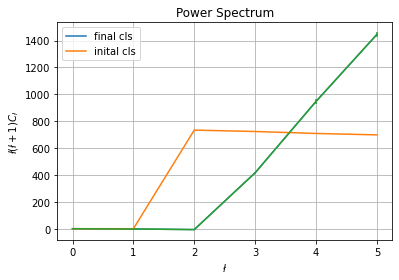

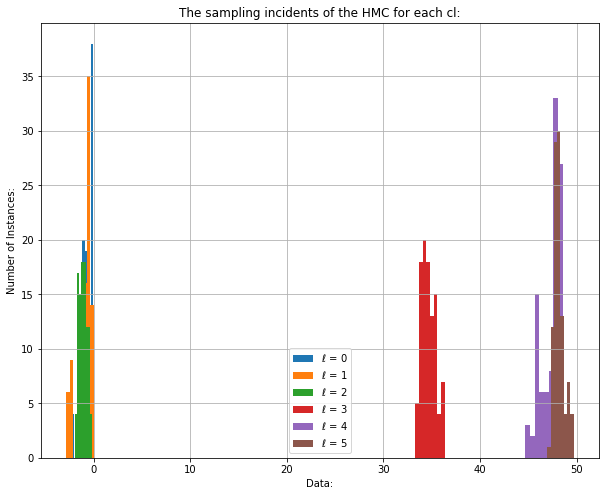

In [210]:
cl_samples = tf.slice(samples2,[0,0],[100,6]) #The sampled cls from the adaptive step size HMC
mean_cl = [tf.math.reduce_mean(cl_samples[:,i])  for i in range(lmax4)] #The mean of the sampled cls from the adaptive step size HMC
std_cl = [tf.math.reduce_std(cl_samples[:,i])  for i in range(lmax4)] #The standard deviation of the = sampled cls from the adaptive step size HMC
plt.figure()
plotpwrspctrm(mean_cl) # Plot of the mean sampled cls
plotpwrspctrm(cls4) #Plot of the original cls
ell = np.arange(lmax4)
plt.errorbar(ell,(ell*(ell+1)*mean_cl),xerr = 0, yerr = (ell*(ell+1)*std_cl))
plt.grid()
plt.legend(('final cls','inital cls'))
plt.show()

plt.figure(figsize = [10,8])
[plt.hist((cl_samples[:,i].numpy()), bins = 8) for i in range(lmax4)] #Histogram of the sampled cls for each l value.
plt.legend((r'$\ell$ = 0','$\ell$ = 1','$\ell$ = 2','$\ell$ = 3','$\ell$ = 4','$\ell$ = 5'))
plt.grid()
plt.xlabel('Data:')
plt.ylabel('Number of Instances:')
plt.title('The sampling incidents of the HMC for each cl:')
plt.show()


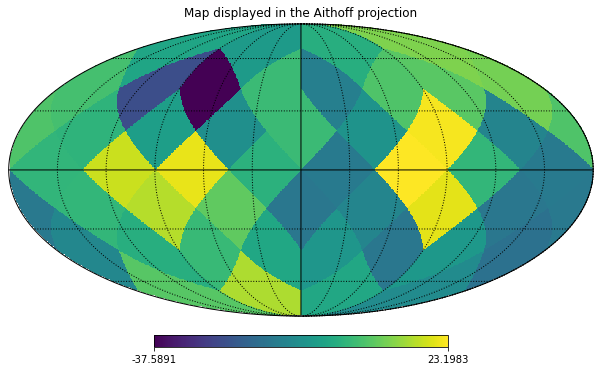

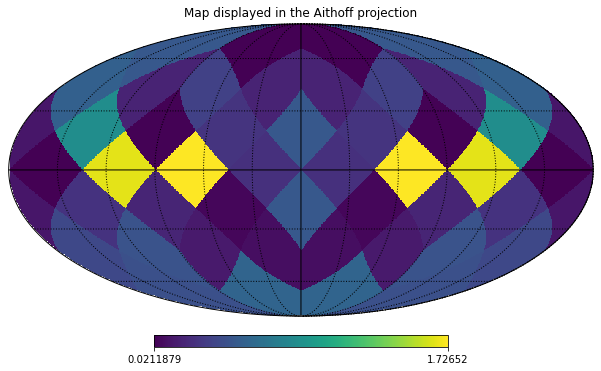

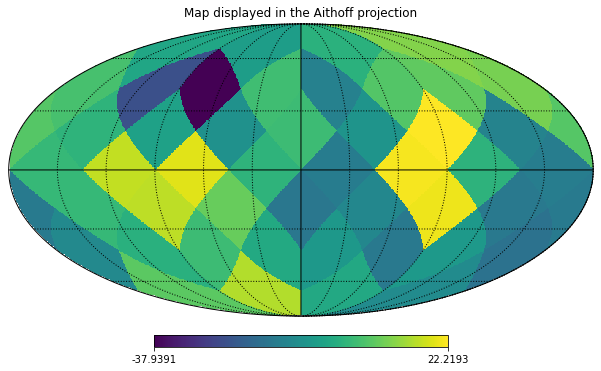

In [222]:
ralm_samples = tf.slice(samples2,[0,6],[100,21]) #The real alm samples from the adaptive step size HMC
ialm_samples = tf.slice(samples2,[0,27],[100,21]) #The imaginary alm samples from the adaptive step size HMC
mean_ralm = [tf.math.reduce_mean(ralm_samples[:,i])  for i in range(len_ralm)] #The mean of all the samples from the real alms
mean_ialm = [tf.math.reduce_mean(ialm_samples[:,i])  for i in range(len_ralm)] #The mean of all the samples from the imaginary alms
std_ralm = [tf.math.reduce_std(ralm_samples[:,i])  for i in range(len_ralm)] #The standard deviation of all the samples from the real alms
std_ialm = [tf.math.reduce_std(ialm_samples[:,i])  for i in range(len_ralm)] #The standard deviation of all the samples from the imaginary alms
mean_alm = splittosingularalm_tf(mean_ralm, mean_ialm) 
mean_map = almtomap_tf(mean_alm,np.int(lmax4/3)) #The mean samples from the HMC as a map

mollviewmap(map4) #Plot of the original map
mollviewmap(mean_map.numpy()) #Plot of the mean samples from the HMC as a map
mollviewmap(map4 - mean_map.numpy()) #A plot of the difference between the original and sampled maps.

In [ ]:
#[insert here where your maps are coming from]


# loop over samples (what we want!)
#saves the frames:
i = 0
for s in Maps:
    # s[0] is the first bin!
    hp.mollview(s[1][0], min=-0.0115, max=0.0115, title="Bin 2 - $\kappa_1$ ")
    N = str(i).zfill(3)
    plty.savefig(f'/path/to/saving/frames/Kappa_2-frame-{N}.png', bbox_to_inches='tight')
    plty.close()
    i += 1

# Creates the gif:
# filepaths
fp_in = "/path/to/saving/frames/Kappa_2-frame-*.png"
fp_out = "/path/to/saving/gifs/kappa_2.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=80, loop=0, optimize=False)
